# Level 1: Rice Crop Discovery Tool Benchmark Notebook

<b>Yesterday's update:</b>

- More clarity on how band values of Sentinel-1 radar data are extracted from Microsoft Planetary Computer system (MPCS) using pystac client.

- Explored 'items' which are image frames (scenes) rendered of Sentinel-1 from MPCS.

- Rendered preview of downloaded scenes of Sentinel-1.

- Naming conventions of Sentinel-1 image frames -- Item: S1B_IW_GRDH_1SDV_20200302T224504_20200302T224537_020519_026E1A_rtc

- View the details of our xarray dataset

- The X and Y dimensions tell us the pixel dimensions of our bounding box

- The "time" variable is the number of scenes that touch our region

- Looking at the data.info of band values 

- Extraction of 'VV' and 'VH' values for various bounding boxes and time of interests for a particular location.

## Challenge Level 1 Overview

<p align="justify">This challenge consists of two levels – Level 1 and Level 2. This is the Level 1 challenge. The goal of Level 1 is to predict the presence of rice crops at a given location using satellite data. Basically building a model which can distinguish between rice and non-rice fields. 
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, the basic model has been built to predict rice crops against non-rice crops (which might include forest, other vegetation and water bodies) using features from the Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, three features have been used from the Sentinel-1 dataset, namely VV (Vertical polarization – Vertical polarization) and VH (Vertical polarization – Horizontal polarization) and VV/VH and trained a logistic regression model with these features. We have extracted the VV band and VH band data from the Sentinel-1 dataset for one year (2012-11-01 to 2022-08-31), for given latitudes and longitudes.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>

## Load In Dependencies

#### Note: Environment setup

This notebook was run on Microsoft Planetary Hub and it requires an API key.

In [2]:
pip install xgboost

  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl (200.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('b77cae5809504d8e8efe5372b65add4b')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

## Response Variable

Before building the model, we need to load in the rice crop presence data. Data has been obtained from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [4]:
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv")
crop_presence_data.head()
#crop_presence_data['Latitude and Longitude'][0]

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


## Predictor Variables

<p align ="justify">Now that with crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
    
<li>VV/VH
</ul>

### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. In this example, we have extracted VV and VH values for a given time period. </p>

In [5]:
def get_sentinel_data(latlong,time_slice,assets,bbox,scale):
    '''
    Returns VV and VH values for a given latitude and longitude from November to August period over Winter-Spring
    2021-2022 season and Summer-Autumn 2022 season
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    #bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    bbox_of_interest = bbox
    time_of_interest = time_slice


    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()
    
    bands_of_interest = assets
    
    vv_list = []
    vh_list = []
    vv_by_vh_list = []
    for item in items:
        data = stac_load([items[1]],bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, crs="EPSG:4326", resolution=scale)
        if(data['vh'].values[0][0]!=-32768.0 and data['vv'].values[0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list.append(np.median(vv))
            vh_list.append(np.median(vh))
            vv_by_vh_list.append(np.median(vv)/np.median(vh))

    
    # #data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    # data = stac_load([items[1]],bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, crs="EPSG:4326", resolution=scale)
    # vh = data["vh"].astype("float").values.tolist()[0][0]
    # vv = data["vv"].astype("float").values.tolist()[0][0]
    # vv_list.append(np.median(vv))
    # #vv_list.append(vv)
    # vh_list.append(np.median(vh))
    # vv_by_vh_list.append(np.median(vv)/np.median(vh))
    
    return vv_list, vh_list, vv_by_vh_list

Exploring the approach of building a bounding box (e.g., 3x3 pixels) around the given latitude and longitude positions and then extracting the aggregated band values (e.g., average, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. In the further updates 5x5 or 7x7 window around the specific latitude and longitude point will be used to get improved results.

In [6]:
# Rice Crop Field in An Giang, Vietnam
def boundingbox(coordinates,box_size_deg):
    # box_size refers to number of pixels to extract across length and width
    lat_long = (10.4391, 105.3338) # Lat-Lon centroid location
    box_size_deg = box_size_deg # Surrounding box in degrees, yields approximately 5x5 pixel region

    min_lon = lat_long[1]-box_size_deg/2
    min_lat = lat_long[0]-box_size_deg/2
    max_lon = lat_long[1]+box_size_deg/2
    max_lat = lat_long[0]+box_size_deg/2

    bbox = (min_lon, min_lat, max_lon, max_lat)
    return bbox

In [7]:
# Time period
time_slice = "2021-11-01/2022-04-30" 

In [116]:
## Get Sentinel-1-RTC Data
assests = ['vh','vv']
train_band_values=crop_presence_data.progress_apply(lambda x: get_sentinel_data(x['Latitude and Longitude'],time_slice,assests,bbox,scale), axis=1)
vh = [x[0] for x in train_band_values]
vv = [x[1] for x in train_band_values]
vv_by_vh = [x[2] for x in train_band_values]
vh_vv_data = pd.DataFrame(list(zip(vh,vv,vv_by_vh)),columns = ["vv_list","vh_list","vv/vh_list"])

100%|██████████| 600/600 [21:54<00:00,  2.19s/it]


In [133]:
vh_vv_data.head()

,vv_list,vh_list,vv/vh_list
0,"[0.14968089014291763, 0.14968089014291763, 0.1...","[0.045613883063197136, 0.045613883063197136, 0...","[3.2814766051716693, 3.2814766051716693, 3.281..."
1,"[0.14968089014291763, 0.14968089014291763, 0.1...","[0.045613883063197136, 0.045613883063197136, 0...","[3.2814766051716693, 3.2814766051716693, 3.281..."
2,"[0.14968089014291763, 0.14968089014291763, 0.1...","[0.045613883063197136, 0.045613883063197136, 0...","[3.2814766051716693, 3.2814766051716693, 3.281..."
3,"[0.14968089014291763, 0.14968089014291763, 0.1...","[0.045613883063197136, 0.045613883063197136, 0...","[3.2814766051716693, 3.2814766051716693, 3.281..."
4,"[0.14968089014291763, 0.14968089014291763, 0.1...","[0.045613883063197136, 0.045613883063197136, 0...","[3.2814766051716693, 3.2814766051716693, 3.281..."


In [ ]:
#Testing
train_band_values=crop_yield_data.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests), axis=1)
vh = [x[0] for x in train_band_values]
vv = [x[1] for x in train_band_values]
vv_by_vh = [x[2] for x in train_band_values]
vh_vv_data = pd.DataFrame(list(zip(vh,vv,vv_by_vh)),columns = ["vv_list","vh_list","vv/vh_list"])

In [85]:
#Testing
coordinates = "(10.323727047081501, 105.2516346045924)"
time_slice = "2020-03-20/2020-03-21"
assests = ['vh','vv']
#bands_v_h = []
train_band_values = lambda x: get_sentinel_data(x,time_slice,assests,bbox,scale)
band_values = train_band_values(coordinates)
band_values[0]

[0.09657388925552368]

In [109]:
#Testing
## Function call to extract VV,VH Values
coordinates = "(10.323727047081501, 105.2516346045924)"
time_slice = "2020-03-01/2020-07-31"
assests = ['vh','vv']
bands_v_h = []
#train_band_values = lambda x: get_sentinel_data(coordinates,time_slice,assests,bbox,scale)
bands_v_h.append(get_sentinel_data(coordinates,time_slice,assests,bbox,scale))
bands_v_h_data = pd.DataFrame(bands_v_h,columns =['vh','vv', 'vv_by_vh'])
bands_v_h_data

,vh,vv,vv_by_vh
0,"[0.1299406886100769, 0.1299406886100769, 0.129...","[0.05558393336832523, 0.05558393336832523, 0.0...","[2.337738276797162, 2.337738276797162, 2.33773..."


In [8]:
def get_sentinel_data1(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    vv_by_vh = vv/vh
    return vh,vv, vv_by_vh

In [96]:
## Function call to extract VV,VH Values
coordinates = "(10.323727047081501, 105.2516346045924)"
time_of_interest = "2020-03-01/2020-04-30"
#box_size_deg = 0.0004
box_size_deg = 0.02035
bbox_of_interest = boundingbox(coordinates, box_size_deg)

# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

assets = ['vh','vv', 'vv_by_vh']
bands_of_interest = ['vv', 'vh']
bbox_of_interest

(105.32362499999999, 10.428925, 105.343975, 10.449275)

In [97]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
items = list(search.get_all_items())

In [98]:
len(items) # Bounding Box: [104.24290738, 8.30183302, 106.89461263, 10.65106386]

15

In [99]:
items

[<Item id=S1A_IW_GRDH_1SDV_20200426T111129_20200426T111154_032298_03BCB9_rtc>,
 <Item id=S1A_IW_GRDH_1SDV_20200425T224542_20200425T224607_032290_03BC6B_rtc>,
 <Item id=S1B_IW_GRDH_1SDV_20200419T224505_20200419T224538_021219_02843B_rtc>,
 <Item id=S1A_IW_GRDH_1SDV_20200414T111128_20200414T111153_032123_03B699_rtc>,
 <Item id=S1A_IW_GRDH_1SDV_20200413T224541_20200413T224606_032115_03B64A_rtc>,
 <Item id=S1B_IW_GRDH_1SDV_20200407T224504_20200407T224538_021044_027EB7_rtc>,
 <Item id=S1A_IW_GRDH_1SDV_20200402T111128_20200402T111153_031948_03B06C_rtc>,
 <Item id=S1A_IW_GRDH_1SDV_20200401T224541_20200401T224606_031940_03B021_rtc>,
 <Item id=S1B_IW_GRDH_1SDV_20200326T224504_20200326T224537_020869_027929_rtc>,
 <Item id=S1A_IW_GRDH_1SDV_20200321T111127_20200321T111152_031773_03AA42_rtc>,
 <Item id=S1A_IW_GRDH_1SDV_20200320T224541_20200320T224606_031765_03A9F6_rtc>,
 <Item id=S1B_IW_GRDH_1SDV_20200314T224504_20200314T224537_020694_0273A6_rtc>,
 <Item id=S1A_IW_GRDH_1SDV_20200309T111127_20200309T

In [100]:
items.reverse()
items[0]

ID: S1B_IW_GRDH_1SDV_20200302T224504_20200302T224537_020519_026E1A_rtc
"Bounding Box: [104.24290738, 8.30183302, 106.89461263, 10.65106386]"
Datetime: 2020-03-02 22:45:20.921299+00:00
datetime: 2020-03-02T22:45:20.921299Z
platform: SENTINEL-1B
"s1:shape: [29098, 27328]"
"proj:bbox: [416600.0, 904170.0, 707580.0, 1177450.0]"
proj:epsg: 32648
"proj:shape: [27328, 29098]"
end_datetime: 2020-03-02 22:45:37.683713+00:00
constellation: Sentinel-1


In [101]:
data = stac_load([items[0]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)

In [102]:
data.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (y: 226, x: 224)
Coordinates:
  * y            (y) float64 1.155e+06 1.155e+06 ... 1.153e+06 1.153e+06
  * x            (x) float64 5.354e+05 5.354e+05 ... 5.376e+05 5.376e+05
    spatial_ref  int32 32648
    time         datetime64[ns] 2020-03-02T22:45:20.921299
Data variables:
    vv           (y, x) float32 0.1703 0.1325 0.08012 ... 0.04729 0.1018 0.294
    vh           (y, x) float32 0.03353 0.02045 0.01334 ... 0.02055 0.04575>

In [164]:
# List of lists of median values of VV, VH, VV/VH of all given locations (latitudes and longitudes)(l) .
# It looks like following: band_values = [[vv_l1, vh_l1, vv/vh_l1],[vv_l2, vh_l2, vv/vh_l2],[vv_l3, vh_l3, vv/vh_l3],[],[],.......]
band_values = [] 
for item in items:
    data = stac_load([item],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    

In [161]:
data.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:      (y: 6, x: 5)
Coordinates:
  * y            (y) float64 1.154e+06 1.154e+06 ... 1.154e+06 1.154e+06
  * x            (x) float64 5.365e+05 5.365e+05 5.365e+05 5.365e+05 5.366e+05
    spatial_ref  int32 32648
    time         datetime64[ns] 2020-04-07T22:45:21.504371
Data variables:
    vv           (y, x) float32 0.0345 0.02033 0.01448 ... 0.04246 0.08085
    vh           (y, x) float32 0.004085 0.002573 0.003848 ... 0.004571 0.01032>

In [200]:
data["vh"].astype("float").values.tolist()[0][0]

0.02623692713677883

In [191]:
m = data.mean()
m.vv

<xarray.DataArray 'vv' ()>
array(0.21718165, dtype=float32)
Coordinates:
    spatial_ref  int32 32648
    time         datetime64[ns] 2020-04-26T11:11:41.514595

In [171]:
vh_0 = data['vh'][0]
np.mean(vh_0)

<xarray.DataArray 'vh' ()>
array(0.02470692, dtype=float32)
Coordinates:
    y            float64 1.154e+06
    spatial_ref  int32 32648
    time         datetime64[ns] 2020-04-26T11:11:41.514595

In [85]:
data['vv']

<xarray.DataArray 'vv' (y: 6, x: 5)>
array([[0.10983712, 0.06619597, 0.03714805, 0.03200791, 0.04629682],
       [0.08411448, 0.05940455, 0.03700041, 0.03750863, 0.05237009],
       [0.07617086, 0.06835178, 0.04557915, 0.02710585, 0.02713038],
       [0.06548975, 0.0545665 , 0.038642  , 0.02502818, 0.0136341 ],
       [0.04939486, 0.03321727, 0.04420258, 0.03664637, 0.02342116],
       [0.03308988, 0.02841637, 0.0489778 , 0.04260162, 0.03000437]],
      dtype=float32)
Coordinates:
  * y            (y) float64 1.154e+06 1.154e+06 ... 1.154e+06 1.154e+06
  * x            (x) float64 5.365e+05 5.365e+05 5.365e+05 5.365e+05 5.366e+05
    spatial_ref  int32 32648
    time         datetime64[ns] 2020-03-02T22:45:20.921299
Attributes:
    nodata:   -32768

In [ ]:
#Testing

bands_v_h = []
#train_band_values = lambda x: get_sentinel_data(coordinates,time_slice,assests,bbox,scale)
bands_v_h.append(get_sentinel_data(coordinates,time_slice,assests,bbox,scale))
bands_v_h_data = pd.DataFrame(bands_v_h,columns =['vh','vv', 'vv_by_vh'])
bands_v_h_data

In [17]:
## Function call to extract VV,VH Values
time_slice = "2020-03-20/2020-03-21"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data1(coordinates,time_slice,assests))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv', 'vv_by_vh'])

100%|██████████| 600/600 [01:45<00:00,  5.68it/s]


## Joining the predictor variables and response variables
Combining extracted band values and location data using concat function 

In [10]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [11]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_data)
crop_data.head()

NameError: name 'crop_presence_data' is not defined

## Model Building


<p align="justify"> Considering only VV, VH and VV/VH features for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

In [20]:
crop_data = crop_data[['vh','vv','Class of Land']]

### Train and Test Split 

Splitting the data into 70% training data and 30%testing data

In [8]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

NameError: name 'crop_data' is not defined

### Feature Scaling 

<p align="justify"> Before initiating the model training, performing different data pre-processing steps. Here we are demonstrating the scaling of VV and VH variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Here we are using Standard Scaler.</p>

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [23]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)

LogisticRegression()

In [33]:
model1 = RandomForestClassifier()
model1.fit(X_train,y_train)

RandomForestClassifier()

## Model Evaluation

### In-Sample Evaluation


In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [24]:
insample_predictions = model.predict(X_train)

In [25]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 60.95%
              precision    recall  f1-score   support

    Non Rice       0.51      0.64      0.57       170
        Rice       0.70      0.59      0.64       250

    accuracy                           0.61       420
   macro avg       0.61      0.61      0.61       420
weighted avg       0.63      0.61      0.61       420



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [26]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

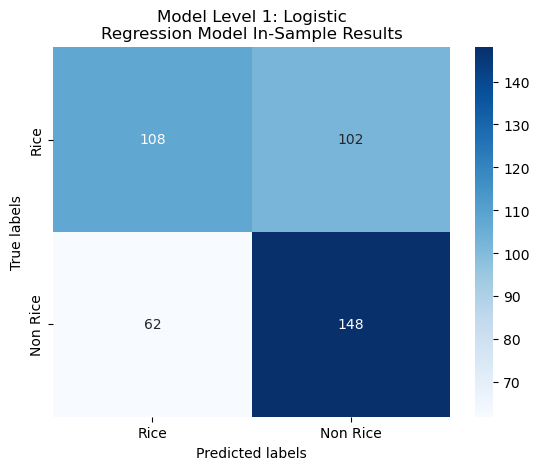

In [27]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation 

For Logitic Regression


In [28]:
outsample_predictions = model.predict(X_test)

In [29]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 56.67%
              precision    recall  f1-score   support

    Non Rice       0.58      0.50      0.54        90
        Rice       0.56      0.63      0.59        90

    accuracy                           0.57       180
   macro avg       0.57      0.57      0.56       180
weighted avg       0.57      0.57      0.56       180



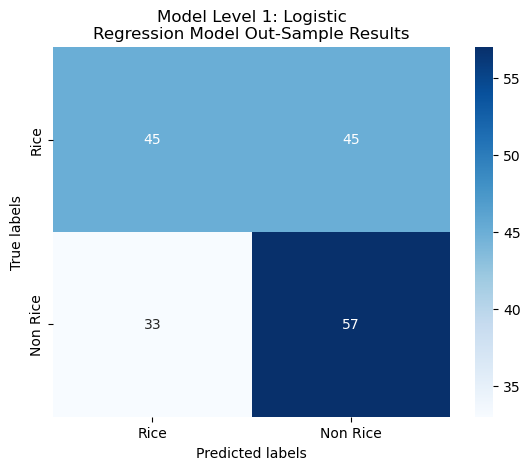

In [30]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.59</b>. This is not a very good score, so your goal is to improve this score.  

For Random Forest Classifier

In [35]:
outsample_predictions1 = model1.predict(X_test)

In [36]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions1, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 69.44%
              precision    recall  f1-score   support

    Non Rice       0.68      0.72      0.70        90
        Rice       0.71      0.67      0.69        90

    accuracy                           0.69       180
   macro avg       0.70      0.69      0.69       180
weighted avg       0.70      0.69      0.69       180



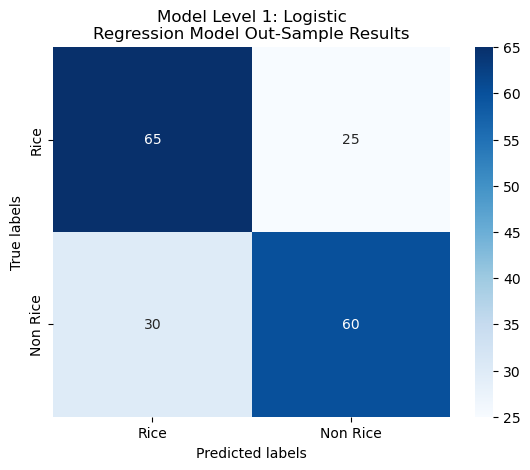

In [37]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

Just by using Random Forest classifier, accuracy of our model increased by 15 percentage points i.e., 69.44% 